Tihs notebook reproduces the binmap plot in the supplement of the paper. 
It generates a binmap plot (presence/absence of a k-mer) colored by antibiotic administration, and paired with information about the fraction of the metagenome/number of base pairs attributable to a given species, and number of bins of that species binned per sample.

There was an issue with aplot that makes it so the plots won't render in a jupyter notebook (https://github.com/YuLab-SMU/aplot/issues/18).
The bug was patched in the repo so I install aplot below directly from github.

In [1]:
remotes::install_github("YuLab-SMU/aplot")

Running `R CMD build`...



* checking for file ‘/private/var/folders/37/wjl5fxrj09j667_w5jrsj34h0000gq/T/Rtmp1Pz8rd/remotes6f713e86239/YuLab-SMU-aplot-f65d437/DESCRIPTION’ ... OK
* preparing ‘aplot’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘aplot_0.1.5.tar.gz’


In [1]:
setwd("..")

In [3]:
library(pagoo)
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(ggplot2)
library(aplot)

## Functions

In [4]:
read_long_sketch_table_as_pagoo <- function(path, threshold = 2000){
  sketch_table <- read_csv(path, show_col_types = F)
  
  # filter samples that don't have enough k-mers for the species
  sketch_table_grp <- sketch_table %>%
    group_by(acc) %>%
    tally()
  
  print(sketch_table_grp)
  
  keep <- sketch_table_grp %>%
    filter(n > threshold)
  
  sketch_table <- sketch_table %>%
    filter(acc %in% keep$acc) %>%
    select(gene    = minhash, 
           org     = acc,
           cluster = minhash) 
  p <- pagoo(data = as.data.frame(sketch_table))
  return(p)
}

In [5]:
plot_binmap <- function(species_string, metadata = h4017, gather_summarized_species, label_x_axis = F) {
  #metadata <- h4017
  #gather_summarized_species = gather_summarized %>% filter(species == "s__Bacteroides fragilis")
  #species_string <- "GCF_003458955.1-s__Bacteroides_fragilis"
  species_string1 <- species_string
  species_string2 <- gsub("-", ".", species_string1)
  species_string3 <- gsub(".*s__", "", species_string2)
  species_string3 <- gsub("_", " ", species_string3)
  species_string4 <- gsub(".*\\.", "", species_string2)
  species_string4 <- gsub("(.*__.*?)_(.*?)", "\\1 \\2 ", species_string4)
  species_string4 <- gsub("  ", " ", species_string4)
  
  pg <- read_long_sketch_table_as_pagoo(paste0("outputs/nbhd_sketch_tables_species/", 
                                               species_string1, "_long.csv"), threshold = 0)
  pg_organisms <- gsub(paste0(".", species_string2), "", as.character(pg$organisms$org))
  metadata <- metadata %>%
    mutate(org = paste0(data_id, ".", species_string2)) %>%
    filter(data_id %in% pg_organisms)
  pg$add_metadata(map = "org", as.data.frame(metadata))
  
  tpm <- t(pg$pan_matrix)
  tpm[which(tpm > 0, arr.ind = TRUE)] <- 1L
  bm <- as.data.frame(tpm)
  or <- order(rowSums(bm), decreasing = TRUE)
  lvls <- rownames(bm)[or]
  bm$Cluster <- factor(rownames(bm), levels = lvls)
  bm <- reshape2::melt(bm, 'Cluster')
  bm$value <- factor(bm$value, levels = c(1, 0))
  bm <- left_join(bm, metadata, by = c("variable" = "org"))
  bm$value_abx <- paste0(bm$value, "_", bm$antibiotics)
  bm$value_abx <- factor(bm$value_abx, levels = c("0_No", "1_No", "0_Yes",  "1_Yes"))
  colnames(bm)[which(colnames(bm) == 'variable')] <- "Organism"
  
  binmap <- ggplot(bm, aes(Cluster, as.factor(week_num), fill=value_abx)) +
    geom_raster() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),
          plot.title = element_text(face = "italic", size = 8),
          axis.text = element_text(size = 7),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 8),
          legend.text = element_text(size = 7),
          legend.position = "none") +
    scale_fill_brewer(palette = "Paired", labels = c("0, No", "1, No", "0, Yes", "1, Yes")) +
    labs(x = "protein k-mer", y = "week number", fill = "presence\n& antibiotics",
         title = species_string3)
  print("bin map plotted")
   
  bp <- ggplot(gather_summarized_species, 
               aes(x = sum_intersect_bp, y = as.factor(week_num))) + 
    geom_col() +
    theme_minimal() +
    xlim(0, 139200000) +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.text = element_text(size = 7),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 8),
          legend.text = element_text(size = 7)) +
    labs(x = "base pairs", y = "week number")
  print("bp plotted")
  
  frac <- ggplot(gather_summarized_species, 
                 aes(x = sum_f_unique_to_query, y = as.factor(week_num))) + 
    geom_col() +
    theme_minimal() +
    xlim(0, 0.31) +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.text = element_text(size = 7),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 8),
          legend.text = element_text(size = 7)) +
    labs(x = "fraction of metagenome", y = "week number")
  print("frac plotted")
  
  n_bins <- ggplot(gather_summarized_species, 
                   aes(x = n_bins, y = as.factor(week_num))) + 
    geom_col() +
    theme_minimal() +
    xlim(0, 4) +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.text = element_text(size = 7),
          axis.title = element_text(size = 8),
          legend.title = element_text(size = 8),
          legend.text = element_text(size = 7)) +
    labs(x = "number of bins", y = "week number")
  print("bins plotted")
    
  if(label_x_axis == F){
    binmap <- binmap + theme(axis.title.x = element_blank())
    bp <- bp + theme(axis.title.x = element_blank())
    frac <- frac + theme(axis.title.x = element_blank())
    n_bins <- n_bins + theme(axis.title.x = element_blank())
  }
  
  plt <- bp %>% aplot::insert_left(binmap) %>% insert_right(frac) %>% insert_right(n_bins)
  return(plt)
}

## Read in hmp metadata and format to samples

In [6]:
destfile <- "inputs/hmp2_metadata.csv"
url <- "https://ibdmdb.org/tunnel/products/HMP2/Metadata/hmp2_metadata.csv"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto")
}
hmp_metadata <- read_csv(destfile, show_col_types = F)

# serology data_type contains information on abx types
# tmp <- hmp_metadata %>%
#   select(participant_id = "Participant ID", data_id = "External ID", data_type,
#          week_num, diagnosis, antibiotics = "Antibiotics",
#          fecalcal, metronidazole = "Flagyl (Metronidazole)",
#          cipro = "Cipro (Ciprofloxin)", rifaxamin = "Xifaxin (rifaxamin)",
#          levaquin = Levaquin, other_abx = "Other Antibiotic:") %>%
#   filter(participant_id =="H4017")

h4017 <- hmp_metadata %>%
  select(data_id = "External ID", data_type,
         week_num, diagnosis, antibiotics = "Antibiotics") %>%
  filter(data_type == "metagenomics") %>%
  filter(data_id %in% c('HSM67VF9', 'HSM67VFD', 'HSM67VFJ', 'HSM6XRQB',
                        'HSM6XRQI', 'HSM6XRQK', 'HSM6XRQM', 'HSM6XRQO',
                        'HSM7CYY7', 'HSM7CYY9', 'HSM7CYYB', 'HSM7CYYD'))

Warning message:
“One or more parsing issues, see `problems()` for details”


## Read in gather results and format

Gather results are used to add the fraction of metagenome estimates to the companion plots alongside the binmap

In [7]:
# read in gtdb lineages
destfile <- "inputs/gtdb-rs202.taxonomy.v2.csv"
url <- "https://osf.io/p6z3w/download"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
gtdb_lineages <- read_csv(destfile, show_col_types = F)

In [8]:
# read in gather results
gather_results <- Sys.glob("outputs/sample_gather/*genomic.csv") %>%
  set_names() %>%
  map_dfr(read_csv, col_types = c("dddddlllcccddddcccd"), .id = "sample") %>%
  mutate(sample = gsub("outputs/sample_gather/", "", sample)) %>%
  mutate(sample = gsub("_gather_gtdb-rs202-genomic.csv", "", sample)) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop")

In [9]:
# join to hmp metadata
gather_results <- left_join(gather_results, gtdb_lineages, by = c("accession" = "ident")) %>%
  left_join(h4017, by = c("sample" = "data_id"))

In [10]:
# filter to sgc species: define common species as those present in all 12 samples
common_species <- gather_results %>%
  select(sample, species) %>%
  distinct() %>%
  group_by(species) %>%
  tally() %>%
  filter(n == 12)

In [11]:
# filter gather results to those in common species AND 
# those that have a f_unique_to_query > 0.2 across samples
sgc_species <- gather_results %>%
  filter(species %in% common_species$species) %>%
  group_by(species) %>%
  summarize(sum_f_unique_to_query = sum(f_unique_to_query)) %>%
  filter(sum_f_unique_to_query > 0.2)

In [12]:
# get per species, per metagenome fractional abundances of each organism
# also get base pairs?
gather_summarized <- gather_results %>%
  filter(species %in% sgc_species$species) %>%
  group_by(sample, species, week_num) %>%
  summarize(sum_f_unique_to_query = sum(f_unique_to_query),
            sum_intersect_bp = sum(intersect_bp))

`summarise()` has grouped output by 'sample', 'species'. You can override using the `.groups` argument.


In [13]:
# add in information about the number of bins per species per sample
bin_info <- Sys.glob("outputs/metabat2_gather_labelled_bins/*txt") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = F, col_names = "bin_name", .id = "species") %>%
  mutate(bin_name = gsub(".sig", "", basename(bin_name)),
         species =  gsub(".*-", "", basename(species)),
         species =  gsub(".txt", "", species),
         species =  gsub("_", " ", species), 
         species =  gsub("  ", "__", species)) %>%
  separate(bin_name, into = c("sample", "bin"), sep = "_") %>%
  group_by(sample, species) %>%
  tally() %>%
  select(sample, species, n_bins = n)

In [14]:
gather_summarized <- left_join(gather_summarized, bin_info) %>%
  mutate(n_bins = replace_na(n_bins, 0))

Joining, by = c("sample", "species")


## Plot binmaps for each sample

In [15]:
bf <- plot_binmap(species_string = "GCF_003458955.1-s__Bacteroides_fragilis",
                  gather_summarized_species = gather_summarized %>% filter(species == "s__Bacteroides fragilis"))
bu <- plot_binmap(species_string = "GCF_009020325.1-s__Bacteroides_uniformis",
                  gather_summarized_species = gather_summarized %>% filter(species == "s__Bacteroides uniformis"))
eb <- plot_binmap(species_string = "GCF_003433765.1-s__Enterocloster_bolteae",
                  gather_summarized_species = gather_summarized %>% filter(species == "s__Enterocloster bolteae"))
pd <- plot_binmap(species_string = "GCA_000162535.1-s__Parabacteroides_distasonis",
                  gather_summarized_species = gather_summarized %>% filter(species == "s__Parabacteroides distasonis"))
pm <- plot_binmap(species_string = "GCF_003475305.1-s__Parabacteroides_merdae", label_x_axis = T,
                  gather_summarized_species = gather_summarized %>% filter(species == "s__Parabacteroides merdae"))
pv <- plot_binmap(species_string = "GCF_009025805.1-s__Phocaeicola_vulgatus", label_x_axis = T,
                  gather_summarized_species = gather_summarized %>% filter(species == "s__Phocaeicola vulgatus"))

# A tibble: 12 × 2
   acc                                                  n
   <chr>                                            <int>
 1 HSM67VF9.GCF_003458955.1.s__Bacteroides_fragilis 16580
 2 HSM67VFD.GCF_003458955.1.s__Bacteroides_fragilis  1441
 3 HSM67VFJ.GCF_003458955.1.s__Bacteroides_fragilis 17116
 4 HSM6XRQB.GCF_003458955.1.s__Bacteroides_fragilis  3281
 5 HSM6XRQI.GCF_003458955.1.s__Bacteroides_fragilis  2640
 6 HSM6XRQK.GCF_003458955.1.s__Bacteroides_fragilis  3523
 7 HSM6XRQM.GCF_003458955.1.s__Bacteroides_fragilis 11473
 8 HSM6XRQO.GCF_003458955.1.s__Bacteroides_fragilis 14979
 9 HSM7CYY7.GCF_003458955.1.s__Bacteroides_fragilis 16727
10 HSM7CYY9.GCF_003458955.1.s__Bacteroides_fragilis 16789
11 HSM7CYYB.GCF_003458955.1.s__Bacteroides_fragilis  2601
12 HSM7CYYD.GCF_003458955.1.s__Bacteroides_fragilis 16905


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



[1] "bin map plotted"
[1] "bp plotted"
[1] "frac plotted"
[1] "bins plotted"
# A tibble: 12 × 2
   acc                                                   n
   <chr>                                             <int>
 1 HSM67VF9.GCF_009020325.1.s__Bacteroides_uniformis  9550
 2 HSM67VFD.GCF_009020325.1.s__Bacteroides_uniformis  1826
 3 HSM67VFJ.GCF_009020325.1.s__Bacteroides_uniformis 15260
 4 HSM6XRQB.GCF_009020325.1.s__Bacteroides_uniformis 16963
 5 HSM6XRQI.GCF_009020325.1.s__Bacteroides_uniformis 16056
 6 HSM6XRQK.GCF_009020325.1.s__Bacteroides_uniformis 17904
 7 HSM6XRQM.GCF_009020325.1.s__Bacteroides_uniformis 18455
 8 HSM6XRQO.GCF_009020325.1.s__Bacteroides_uniformis 17755
 9 HSM7CYY7.GCF_009020325.1.s__Bacteroides_uniformis 17231
10 HSM7CYY9.GCF_009020325.1.s__Bacteroides_uniformis 16307
11 HSM7CYYB.GCF_009020325.1.s__Bacteroides_uniformis   396
12 HSM7CYYD.GCF_009020325.1.s__Bacteroides_uniformis 16224


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



[1] "bin map plotted"
[1] "bp plotted"
[1] "frac plotted"
[1] "bins plotted"
# A tibble: 12 × 2
   acc                                                   n
   <chr>                                             <int>
 1 HSM67VF9.GCF_003433765.1.s__Enterocloster_bolteae    67
 2 HSM67VFD.GCF_003433765.1.s__Enterocloster_bolteae   505
 3 HSM67VFJ.GCF_003433765.1.s__Enterocloster_bolteae 11460
 4 HSM6XRQB.GCF_003433765.1.s__Enterocloster_bolteae 17025
 5 HSM6XRQI.GCF_003433765.1.s__Enterocloster_bolteae  5361
 6 HSM6XRQK.GCF_003433765.1.s__Enterocloster_bolteae  6797
 7 HSM6XRQM.GCF_003433765.1.s__Enterocloster_bolteae  4536
 8 HSM6XRQO.GCF_003433765.1.s__Enterocloster_bolteae  2846
 9 HSM7CYY7.GCF_003433765.1.s__Enterocloster_bolteae 17469
10 HSM7CYY9.GCF_003433765.1.s__Enterocloster_bolteae  7647
11 HSM7CYYB.GCF_003433765.1.s__Enterocloster_bolteae    96
12 HSM7CYYD.GCF_003433765.1.s__Enterocloster_bolteae 14602


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



[1] "bin map plotted"
[1] "bp plotted"
[1] "frac plotted"
[1] "bins plotted"
# A tibble: 12 × 2
   acc                                                        n
   <chr>                                                  <int>
 1 HSM67VF9.GCA_000162535.1.s__Parabacteroides_distasonis 11766
 2 HSM67VFD.GCA_000162535.1.s__Parabacteroides_distasonis  2209
 3 HSM67VFJ.GCA_000162535.1.s__Parabacteroides_distasonis 15418
 4 HSM6XRQB.GCA_000162535.1.s__Parabacteroides_distasonis  3131
 5 HSM6XRQI.GCA_000162535.1.s__Parabacteroides_distasonis  9938
 6 HSM6XRQK.GCA_000162535.1.s__Parabacteroides_distasonis  3990
 7 HSM6XRQM.GCA_000162535.1.s__Parabacteroides_distasonis 16597
 8 HSM6XRQO.GCA_000162535.1.s__Parabacteroides_distasonis 14632
 9 HSM7CYY7.GCA_000162535.1.s__Parabacteroides_distasonis 15293
10 HSM7CYY9.GCA_000162535.1.s__Parabacteroides_distasonis 15823
11 HSM7CYYB.GCA_000162535.1.s__Parabacteroides_distasonis   140
12 HSM7CYYD.GCA_000162535.1.s__Parabacteroides_distasonis 16063


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



[1] "bin map plotted"
[1] "bp plotted"
[1] "frac plotted"
[1] "bins plotted"
# A tibble: 12 × 2
   acc                                                    n
   <chr>                                              <int>
 1 HSM67VF9.GCF_003475305.1.s__Parabacteroides_merdae 11602
 2 HSM67VFD.GCF_003475305.1.s__Parabacteroides_merdae 13932
 3 HSM67VFJ.GCF_003475305.1.s__Parabacteroides_merdae 14278
 4 HSM6XRQB.GCF_003475305.1.s__Parabacteroides_merdae  2310
 5 HSM6XRQI.GCF_003475305.1.s__Parabacteroides_merdae  2095
 6 HSM6XRQK.GCF_003475305.1.s__Parabacteroides_merdae  2437
 7 HSM6XRQM.GCF_003475305.1.s__Parabacteroides_merdae  3126
 8 HSM6XRQO.GCF_003475305.1.s__Parabacteroides_merdae  2878
 9 HSM7CYY7.GCF_003475305.1.s__Parabacteroides_merdae 14540
10 HSM7CYY9.GCF_003475305.1.s__Parabacteroides_merdae 14982
11 HSM7CYYB.GCF_003475305.1.s__Parabacteroides_merdae   182
12 HSM7CYYD.GCF_003475305.1.s__Parabacteroides_merdae 15429


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



[1] "bin map plotted"
[1] "bp plotted"
[1] "frac plotted"
[1] "bins plotted"
# A tibble: 12 × 2
   acc                                                  n
   <chr>                                            <int>
 1 HSM67VF9.GCF_009025805.1.s__Phocaeicola_vulgatus 17158
 2 HSM67VFD.GCF_009025805.1.s__Phocaeicola_vulgatus 16658
 3 HSM67VFJ.GCF_009025805.1.s__Phocaeicola_vulgatus 15713
 4 HSM6XRQB.GCF_009025805.1.s__Phocaeicola_vulgatus 18966
 5 HSM6XRQI.GCF_009025805.1.s__Phocaeicola_vulgatus 18147
 6 HSM6XRQK.GCF_009025805.1.s__Phocaeicola_vulgatus 20036
 7 HSM6XRQM.GCF_009025805.1.s__Phocaeicola_vulgatus 21421
 8 HSM6XRQO.GCF_009025805.1.s__Phocaeicola_vulgatus 20649
 9 HSM7CYY7.GCF_009025805.1.s__Phocaeicola_vulgatus 15010
10 HSM7CYY9.GCF_009025805.1.s__Phocaeicola_vulgatus 15656
11 HSM7CYYB.GCF_009025805.1.s__Phocaeicola_vulgatus  1044
12 HSM7CYYD.GCF_009025805.1.s__Phocaeicola_vulgatus 16262


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



[1] "bin map plotted"
[1] "bp plotted"
[1] "frac plotted"
[1] "bins plotted"


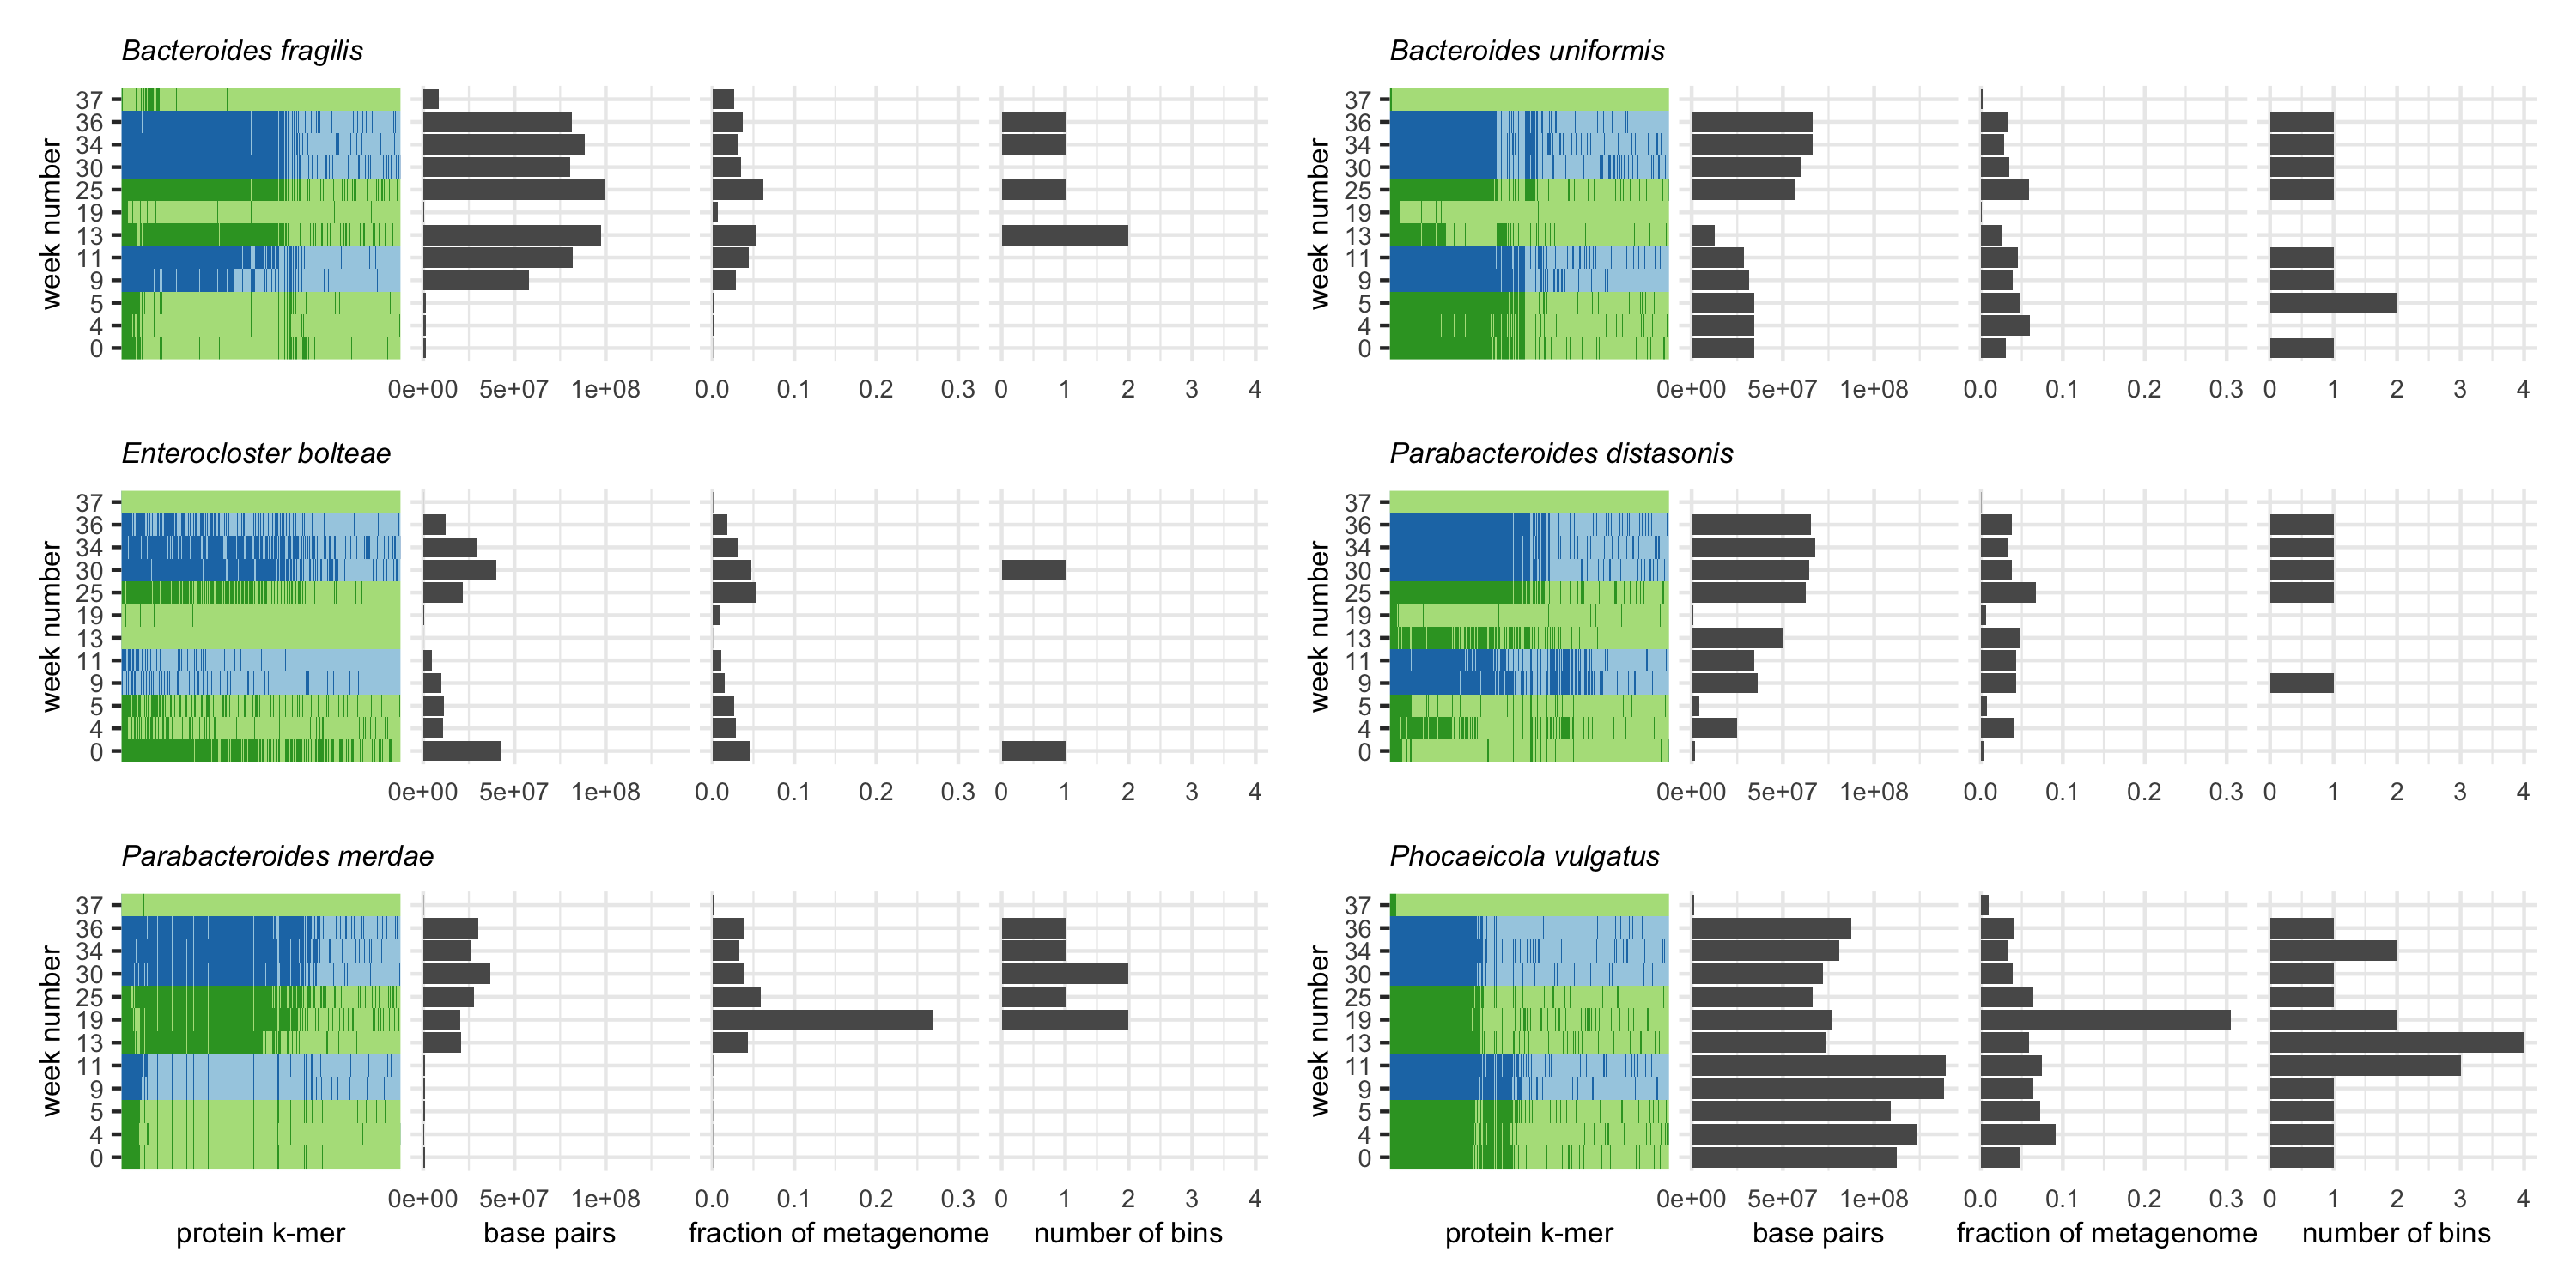

In [16]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

#png("tmp100.png", height = 5, width = 10, res = 300, units = "in")
plot_list(bf, bu, eb, pd, pm, pv, nrow = 3, ncol = 2, heights = c(1, 1, 1.1))
#dev.off()

## add a legend to the plot

make a contingency table plot, and join to plot as a legend

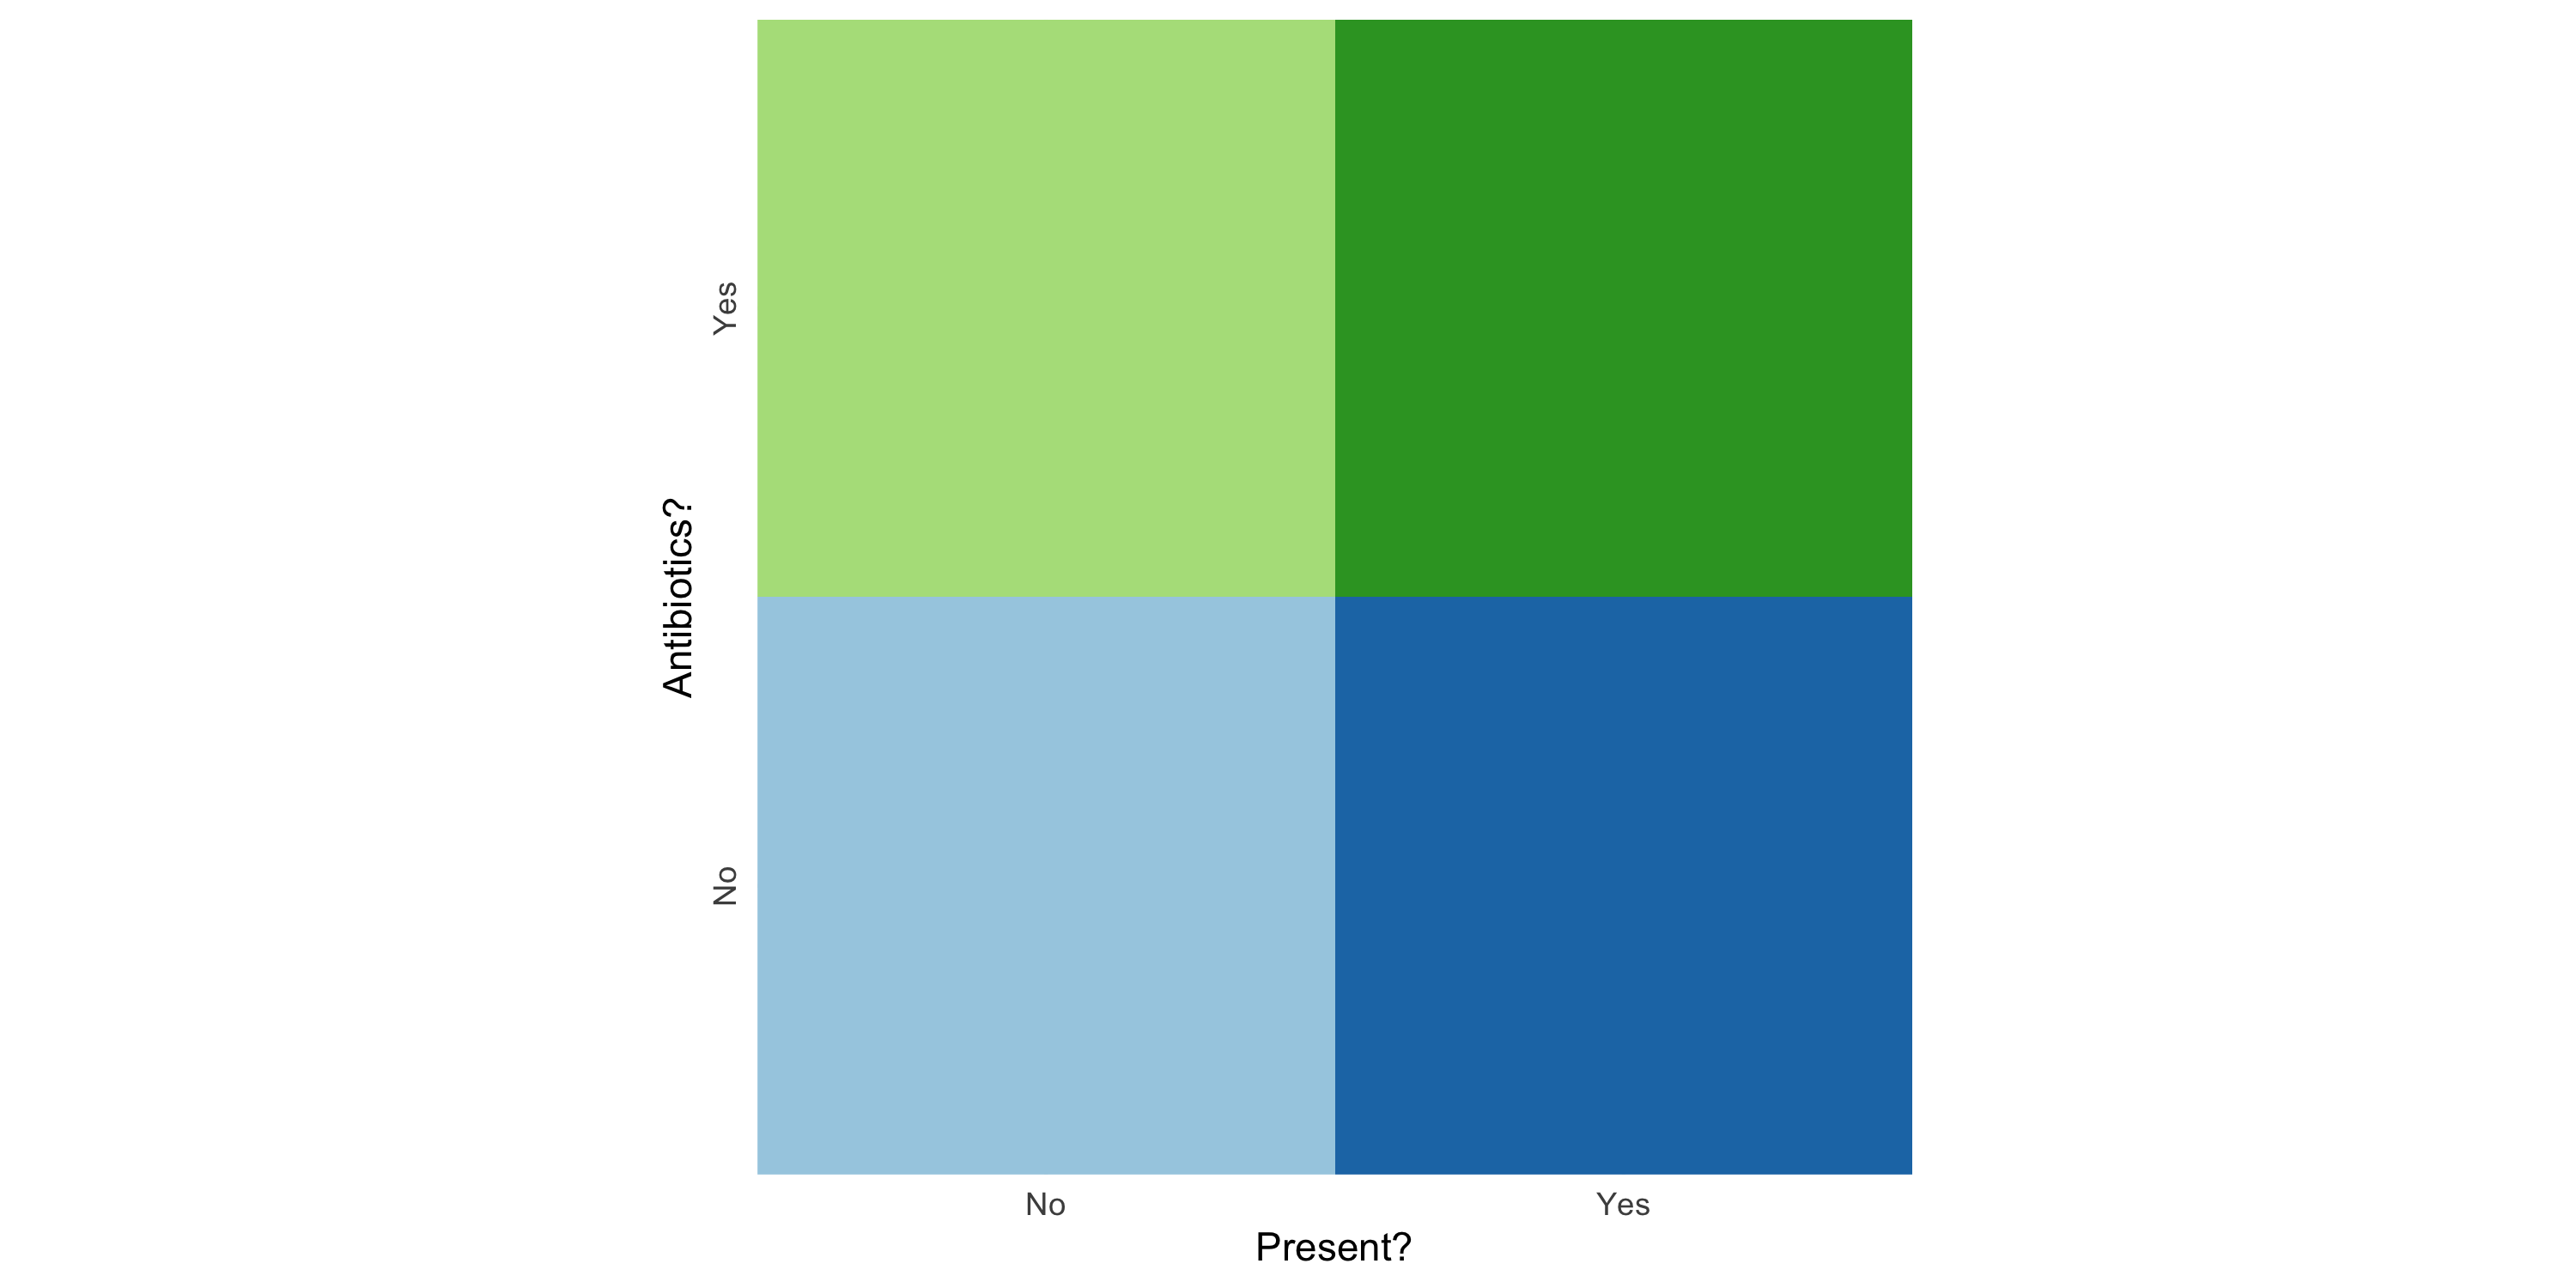

In [33]:
legend_data <- data.frame(antibiotics = c("No", "No", "Yes", "Yes"),
                          presence = c("No", "Yes", "No", "Yes")) %>% 
  mutate(indicator = interaction(antibiotics, presence, sep = ":"))

legend_binmap <- ggplot(legend_data, aes(x = presence, y = antibiotics, fill = indicator)) +
  geom_tile(show.legend = F) + 
  scale_x_discrete("Present?", expand = c(0,0)) +
  scale_y_discrete("Antibiotics?",  expand = c(0,0)) + 
  theme_minimal() +
  theme(axis.text.y = element_text(angle = 90, hjust = 0.5)) +
  coord_equal() +
  scale_fill_manual(values = c("#A6CEE3", "#B2DF8A", "#1F78B4", "#33A02C"))

legend_binmap

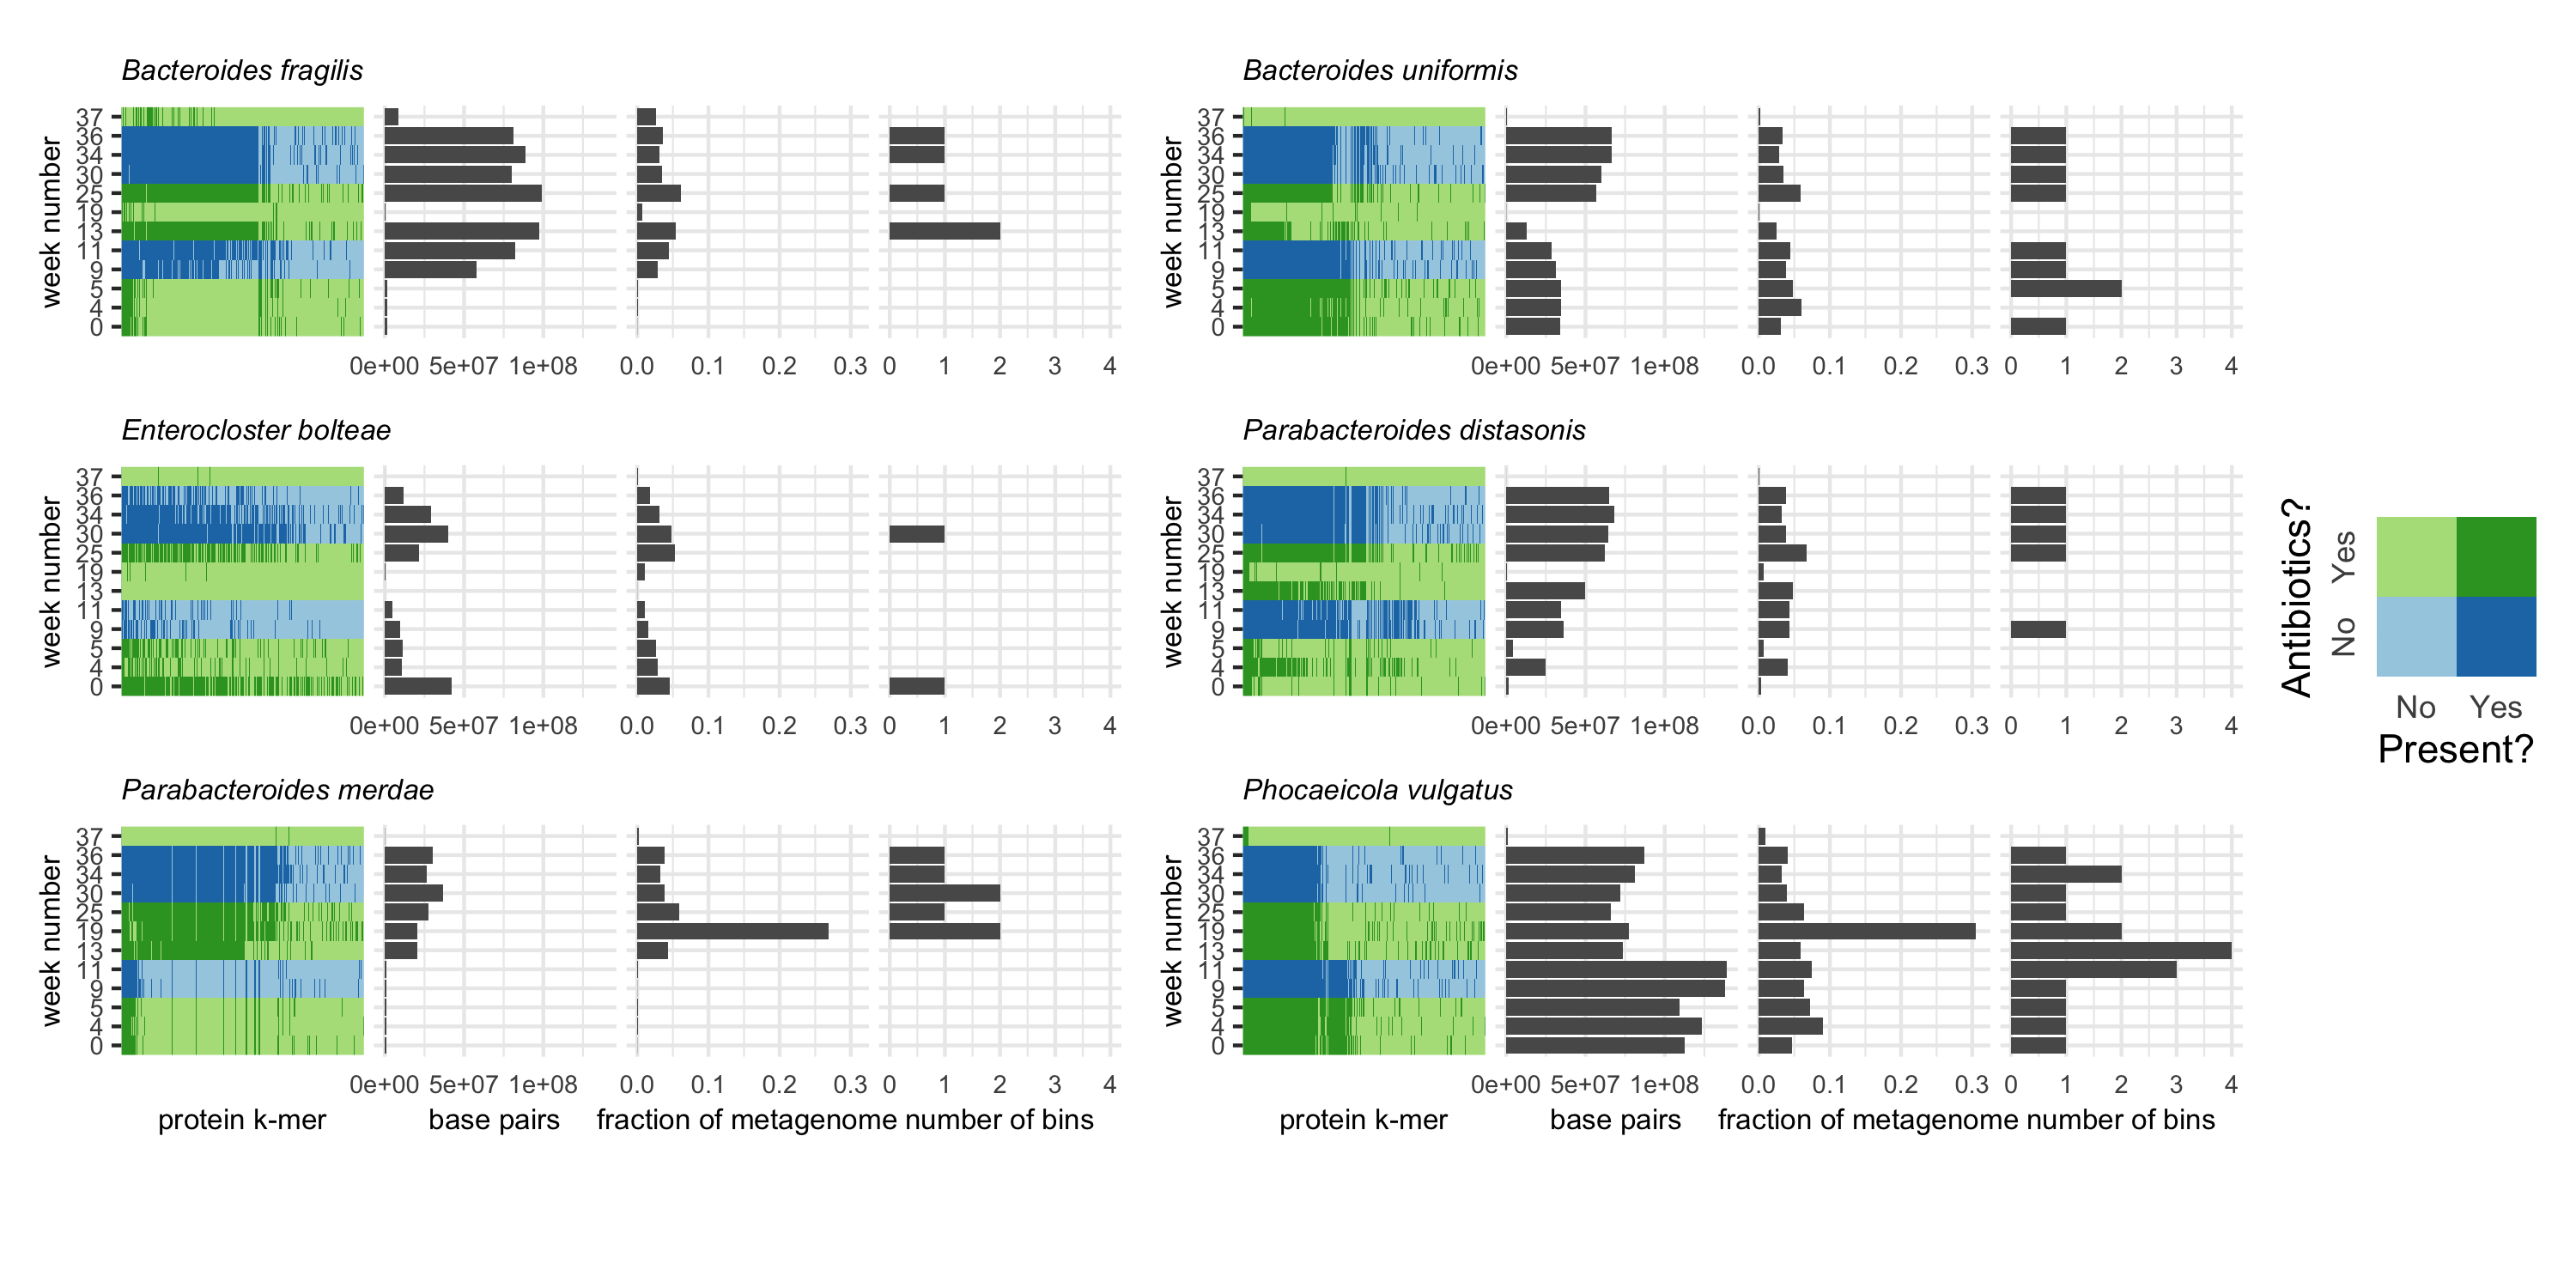

In [43]:
# if on same system as paper repo:
#png("../2021-paper-metapangenomes/content/images/metap.png", height = 6, width = 11, res = 300, units = "in")
plot_list(plot_list(bf, bu, eb, pd, pm, pv, nrow = 3, ncol = 2, heights = c(1, 1, 1.1)), 
          legend_binmap, ncol = 2, widths = c(14, 1))
          #ggpubr::as_ggplot(cowplot::get_legend(binmap)), nrow = 2, heights = c(7, 1))
#dev.off()